In [ ]:
%%capture --no-stderr
!pip install -U langchain langchain_community pypdf sentence_transformers chromadb

In [ ]:
import langchain, langchain_community, pypdf, sentence_transformers, chromadb

for module in (langchain, langchain_community, pypdf, sentence_transformers, chromadb):
    print(f"{module.__name__:<30}{module.__version__}")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


langchain                     0.2.10
langchain_community           0.2.9
pypdf                         4.3.1
sentence_transformers         3.0.1
chromadb                      0.5.5


In [ ]:
import os
import pandas as pd

from langchain_community.vectorstores import Chroma

In [ ]:
# 如果已经下载到本地，可以替换为本地路径
EMBEDDING_MODEL_PATH = 'BAAI/bge-large-zh-v1.5'
dt = '20240713'
version = 'v1'

output_dir = os.path.join('outputs', f'{version}_{dt}')

# 文档处理

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

## 文档加载

In [ ]:
loader = PyPDFLoader("data/2024全球经济金融展望报告.pdf")
documents = loader.load()

In [ ]:
qa_df = pd.read_excel(os.path.join(output_dir, 'question_answer.xlsx'))

## 文档切分

In [ ]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [ ]:
splitted_docs = split_docs(documents, os.path.join(output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


## 向量化

In [ ]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

embeddings = HuggingFaceBgeEmbeddings(
    model_name=EMBEDDING_MODEL_PATH,
    model_kwargs={'device': device},
    encode_kwargs={'normalize_embeddings': True}
)

device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/30.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/439k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
from tqdm.auto import tqdm

def get_vector_db(docs, store_path, force_rebuild=False):
    if not os.path.exists(store_path):
        force_rebuild = True

    if force_rebuild:
        vector_db = Chroma.from_documents(
            docs,
            embedding=embeddings,
            persist_directory=store_path
        )
    else:
        vector_db = Chroma(
            persist_directory=store_path,
            embedding_function=embeddings
        )
    return vector_db

In [ ]:
vector_db = get_vector_db(splitted_docs, store_path=os.path.join(output_dir, 'chromadb', 'bge_large_v1.5'))

# 检索

In [ ]:
def retrieve(vector_db, query: str, k=5):
    return vector_db.similarity_search(query, k=k)

## 计算检索准确率

In [ ]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [ ]:
len(test_df)

93

In [ ]:
top_k_arr = list(range(1, 9))
hit_stat_data = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    question = row['question']
    true_uuid = row['uuid']
    chunks = retrieve(vector_db, question, k=max(top_k_arr))
    retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

    for k in top_k_arr:
        hit_stat_data.append({
            'question': question,
            'top_k': k,
            'hit': int(true_uuid in retrieved_uuids[:k])
        })

  0%|          | 0/93 [00:00<?, ?it/s]

In [ ]:
hit_stat_df = pd.DataFrame(hit_stat_data)

In [ ]:
hit_stat_df.sample(5)

,question,top_k,hit
340,2023年10月欧元区经济景气指数是多少点?,5,0
450,欧洲央行在3月16日的利率是多少百分比?,3,1
743,商业房地产贷款在中小型银行资产中的占比大约是多少？,8,1
88,全球经济复苏呈现什么特点？,1,0
367,2023年9月南非的CPI同比上涨了多少？,8,1


In [ ]:
import seaborn as sns

In [ ]:
hit_stat_df.groupby('top_k')['hit'].mean().reset_index()

,top_k,hit
0,1,0.462366
1,2,0.591398
2,3,0.688172
3,4,0.774194
4,5,0.806452
5,6,0.817204
6,7,0.838710
7,8,0.849462


<Axes: xlabel='top_k', ylabel='hit'>

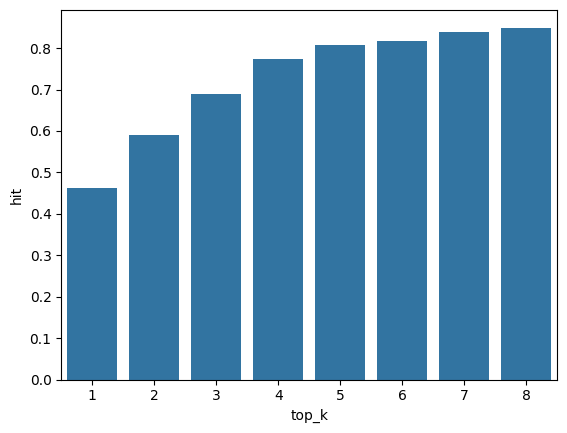

In [ ]:
sns.barplot(x='top_k', y='hit', data=hit_stat_df.groupby('top_k')['hit'].mean().reset_index())

# 问答

## 流式处理

In [ ]:
from langchain.llms import Ollama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

llm = Ollama(
    model='qwen2:7b-instruct',
    base_url="http://localhost:11434"
)

prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{context}
<<<</context>>>

问题：{question}
请回答：
"""
prompt = PromptTemplate.from_template(prompt_tmpl)
retriever = vector_db.as_retriever(search_kwargs={'k': 4})

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in rag_chain.stream("2023年10月美国ISM制造业PMI指数较上月有何变化？"):
    print(chunk, end="", flush=True)

2023年10月美国ISM制造业PMI指数较上个月大幅下降2.3个百分点。

## 非流式输出

In [ ]:
print(rag_chain.invoke('2023年10月美国ISM制造业PMI指数较上月有何变化？'))

2023年10月美国ISM制造业PMI指数较上个月大幅下降了2.3个百分点。


## 流程拆解

In [ ]:
llm = Ollama(
    model='qwen2:7b-instruct',
    base_url="http://localhost:11434"
)

In [ ]:
llm.invoke('你是谁')

'我是阿里云开发的一款超大规模语言模型，我叫通义千问。作为一个AI助手，我的目标是帮助用户获得准确、有用的信息，解决他们的问题和疑惑。我可以回答各种领域的问题、提供信息查询、解释概念、辅助学习等。请随时向我提问或寻求帮助，我会尽力提供支持。如果您有任何问题或需要解答，请尽管告诉我！'

In [ ]:
def rag(query, n_chunks=5):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()

    chunks = retrieve(vector_db, question, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)

    return llm(prompt), [doc.page_content for doc in chunks]

In [ ]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']]

answer_dict = {}

In [ ]:
for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
    uuid = row['uuid']
    question = row['question']
    answer, context = rag(question, n_chunks=4)
    answer_dict[question] = {
        'uuid': uuid,
        'ref_answer': row['answer'],
        'gen_answer': answer,
        'context': context
    }

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [ ]:
prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
prediction_df.loc[:, 'context'] = prediction_df['question'].apply(lambda q: answer_dict[q]['context'])

In [ ]:
prediction_df.sample(5)

,uuid,question,qa_type,answer,gen_answer,context
136,3c0da094-8444-428b-9729-f1caa33e4b06,2023年二季度沙特GDP的同比增长率是多少？,detailed,1.2%,2023年二季度沙特GDP同比仅增长1.2%。,[全球经济金融展望报告\n中国银行研究院 40 2024年\n注重绿色经济发展，为中海经贸合...
168,9d41e5b3-2a8c-4584-b7b2-a6b7489758c9,日本央行的基准利率在10月31日维持在多少？,detailed,-0.1%,日本央银在10月31日将基准利率维持在-0.1%的水平。,[全球经济金融展望报告\n中国银行研究院 17 2024年\n图11：日本GDP环比增长折年...
5,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,展望2024年，全球经济复苏的预期如何？,detailed,全球经济复苏预计将依旧疲软。,2024年全球经济复苏预期将较为疲软，并可能出现进一步分化。发达经济体将面临“遏通胀和稳增长...,[全球经济金融展望报告\n中国银行研究院 2 2024年\n图1：全球GDP增速（%）\n资...
51,0a58414c-bf99-493b-b13b-b83c96af2687,世贸组织对2023年全球货物贸易增速的预测值是多少百分点?,detailed,0.9个百分点,世贸组织将2023年全球货物贸易增速预测值下调至0.8%，为近几年最低水平。,[全球经济金融展望报告\n中国银行研究院 7 2024年\n（图7）。10月，世贸组织将20...
265,28c7d4f0-8cea-48b3-9cfa-6683446fd425,海湾六国经济结构的主要问题是什么？,detailed,经济结构相对单一,海湾六国经济结构的主要问题是过于依赖传统能源，尤其是石油和天然气，这在一定程度上限制了工业发...,[全球经济金融展望报告\n中国银行研究院 41 2024年\n湾六国经济增长提供一定支撑，但...
